#### Der diskrete Bayes-Filter zum Tracken eines Roboterfahrzeugs, Teil 1
24.10.2023, S. Mack

**Der Kalman-Filter ist eine Untergruppe der g-h-Filter und gehört zu den *Bayes-Filtern*.**  
Wikipedia definiert den Bayes-Filter wie folgt: 
> "Der Bayessche Filter oder Bayes-Filter ist ein rekursives, probabilistisches Verfahren zur Schätzung von Wahrscheinlichkeitsverteilungen unbeobachteter Zustände eines Systems bei gegeben Beobachtungen und Messungen."  
Wie beim bisher schon behandelten g-h-Filter geht es also um *Schätzungen* von *Zustandswerten* aufgrund von *Messungen* mit Hilfe eines *rekursiven = iterativen* Verfahrens. Neu am Bayes-Filter ist der Begriff "*Wahrscheinlichkeitsverteilung*".  

Es geht nun also um *Wahrscheinlichkeitsrechnung*.  
Beim g-h-Filter spielten Unsicherheiten der Vorhersage oder der Messung keine Rolle. Insbesondere die Skalierungsfaktoren $g$ und $h$, wo sich das Vertrauen auf die Messung vs. Vorhersage wiederspiegelt, wurden willkürlich als Konstanten festgelegt. Im Gegensatz dazu *spielen beim Bayes-Filter die Wahrscheinlichkeitsverteilungen eine zentrale Rolle*.  
Wie schon erwähnt, orientiert sich die kommende Erklärung des diskreten Bayes-Filters am Jupyter-Notebook von R. Labbe.
  
Der Bayes-Filter wird nachfolgend nicht wie (leider) in vielen Lehrbüchern zuerst mathematisch hergeleitet, sondern anwendungsorientiert über mehrere Gedankenexperimente erklärt. Die grundlegende Mathematik hierzu wird kurz am Ende dieses Jupyter-Notebooks "nachgereicht".  
**Bitte beachten:** Nachfolgend geht es um den *diskreten* Bayesfilter. Hier sind nicht nur der Zeitablauf sondern auch die Zustandswerte diskontinuierlich. Letztere stehen im vorliegenden Beispiel für die Position, welche nur diskrete Werte annehmen kann. Wenn in diesem und in den folgenden Jupyter-Notebooks die Rede vom "Bayes-Filter" ist, dann ist damit immer der "*diskrete* Bayes-Filter" gemeint.

## Einführung Bayes-Statistik: Tracking eines Roboterfahrzeugs entlang eines Flurs

<img src="RoboFahrzeugParallelTuerenFlur.png" width="800">

Wie in der Skizze oben dargestellt, fährt das Roboterfahrzeug parallel zur Wand einen langen schmalen Flur entlang. Auf einer Seite des Flurs gehen in gleichen Abständen insgesamt zehn Türen ab, welche mit den Ziffern 0 bis 9 von Links nach Rechts durchnummeriert sind.  
Jetzt geht es nicht mehr darum, dass das Fahrzeug mithilfe seines Abstandssensors parallel zur Wand fährt. Dieses Problem sei gelöst: Das Fahrzeug fährt immer den Flur entlang, egal ob eine Türe geöffnet ist oder nicht. (Diese Bahn hält es beispielsweise mit Hilfe eines Liniensensors ein, in dem es einer Linie auf dem Flurboden folgt.)

Das Fahrzeug kann sich jetzt vorwärts oder rückwärts (oben im Bild nach Links oder nach Rechts) bewegen und ist innerhalb einer Sekunde zur nächsten Türe gefahren. Es hat zwei neue Sensoren: Diese erfassen einmal pro Sekunde folgende Zustandswerte:  
+ **Sensor 1 misst die Bewegung des Fahrzeugs:** Nach Links zur nächsten Türe (Sensorwert -1), nach Rechts zur nächsten Türe (Sensorwert 1) oder Stillstand (Sensorwert 0).
+ **Sensor 2 misst den Zustand Türe an der Position des Fahrzeugs:** Offene Türe (Sensorwert 1) oder geschlossene Türe (Sensorwert 0).

Eine mögliche Abfolge von Sensordaten sind folgende:  

Sample | Zustand Bewegung | Wert Bewegungssensor | Zustand Türe | Wert Türsensor
--- | --- |--- | --- | ---
1 | links | -1 | offen | 1
2 | links | -1 | geschlossen | 0
3 | links | -1 | geschlossen | 0
4 | rechts | +1 | geschlossen | 0
5 | rechts | +1 | offen | 1
6 | still | 0 | offen | 1
... | ... | ... | ... | ...


>Die Aufgabe des Bayes-Filters ist es, mit Hilfe dieser beiden Sensordaten die Position des Fahrzeugs im Flur zu schätzen, also vorherzusagen, vor welcher Tür sich das Fahrzeug gerade mit welcher Wahrscheinlichkeit befindet. Dies wird nachfolgend auch "Positionsannahme" (engl. position belief) genannt. Die Position des Fahrzeugs ist der "*unbeobachtete Zustand*" aus der Wikipedia-Definition des Bayes-Filters. 

**Dies geht aber nur mit zusätzlichem Wissen darüber, welche Türe im Flur geöffnet ist und welche nicht.** Diese Information ist im ``NumPy``-Array ``hallway`` abgelegt. Eine 1 steht für eine offene und eine 0 für eine geschlossene Türe.  

Zu Beginn liegt keine Information zur Position des Fahrzeugs im Flur vor. Es gibt zehn Türen, also zehn mögliche Positionen. Mangels Anfangsinformationen muss also angenommen werden, dass sich das Fahrzeug mit gleicher Wahrscheinlichkeit vor jeder der Türen befinden kann: Die Wahrscheinlichkeit für jede Türposition beträgt also 1/10.  
Diese Positionsannahme wird in Form von Wahrscheinlichkeitsverteilungen über den ``NumPy``-Array ``belief`` repräsentiert: Dem Index 0 dieses Arrays ist die Türe 0, dem Index 1 die Türe 1, dem Index 2 die Türe 2 usw. zugeordnet.

In [1]:
import numpy as np
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]) # 1 stands for open door at this index position
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


>In der Bayes-Statistik wird die Positionsannahme, *bevor* neue Messdaten für eine Korrektur einbezogen werden, als "Prior" oder "A-Priori-Wahrscheinlichkeitsverteilung" bezeichnet.

In diesem Wahrscheinlichkeitsverteilungs-Array kommen als Indizes alle möglichen Zustandswerte des Systems vor. Daher muss die Quersumme des Arrays den Wert Eins ergeben, denn einen dieser vielen Zustandwerte muss das System tatsächlich besitzen.  

### Bayes-Statistik im Vergleich zur klassischen Statistik
Die Bayes-Statistik ist ein Zweig der allgemeinen mathematischen Statistik.  
Die klassische Statistik setzt im Gegensatz zur Bayes-Statistik unendlich oft wiederholbare Zufallsexperimente voraus. Ein prominentes Beispiel hierfür ist das Würfeln: Wenn man unendlich oft würfelt, dann wird man z.B. im Mittel genau 3,5 Augen erreichen oder zu genau 1/6 Einsen gewürfelt haben.  
>Für die Bayes-Statistik bedeutet "Wahrscheinlichkeit" im Gegensatz dazu nicht "Häufigkeit" sondern "Annahme" (engl. belief), dass ein bestimmter Zustandswert vorliegt, ohne dies beweisen zu können.  

Die klassische Wahrscheinlichkeitstheorie macht keine Annahme über den Ausgang eines konkreten "Würfelereignisses". Die Bayes-Statistik hingegen zieht Informationen aus der Vergangenheit (den Prior) mit heran und *macht* eine Annahme darüber, welche Augenzahl am wahrscheinlichsten für den gerade geworfenen Würfel ist. Bei einem Würfel wirkt sich die Vergangenheit natürlich nicht aus. Daher ist hier die Bayes-Statistik auch fehl am Platz.  

Anders ist das z.B. bei der Wettervorhersage: Hier ist auch viel Statistik im Spiel, und das Wetter morgen hängt stark vom Wetter heute ab.  

Zurück zum Roboterfahrzeug: Auch für das Fahrzeug ist die Wahrscheinlichkeit für eine bestimmte Türposition abhängig von der Vergangenheit, denn das Fahrzeug kann pro Sekunde maximal um eine Türe weiter fahren. 

## Berechnung der Wahrscheinlichkeitsverteilung unter Berücksichtigung unverrauschter Messdaten
### Exemplarisches Beispiel: Konkretisierung der Positionsannahme alleine durch Türmessdaten

Weiter geht es mit dem Gedankenexperiment: Zunächst werden nur die Messdaten bezüglich der Türen (offen oder geschlossen) verwendet. Die Startposition des Fahrzeugs sei nicht bekannt. Der Bewegungssensor wird in diesem Abschnitt noch nicht verwendet.    
Die erste Messung ergibt den Messwert "Türe geschlossen". Mit dieser Information zusammen mit dem Array ``hallway`` (enthält Infos über die Positionen der geöffneten Türen) lässt sich eine Annahme zur Position des Fahrzeugs berechnen: Es gibt nur drei geöffnete Türen an den Positionen 0,1 und 8. Folglich ist die Wahrscheinlichkeit der Fahrzeugposition an jeder dieser drei Positionen gleich 1/3. Diese Wahrscheinlichkeitsverteilung quantifiziert also die Annahme über die Fahrzeugposition.  

Das folgende Histogramm visualisiert diese Wahrscheinlichkeitsverteilung:

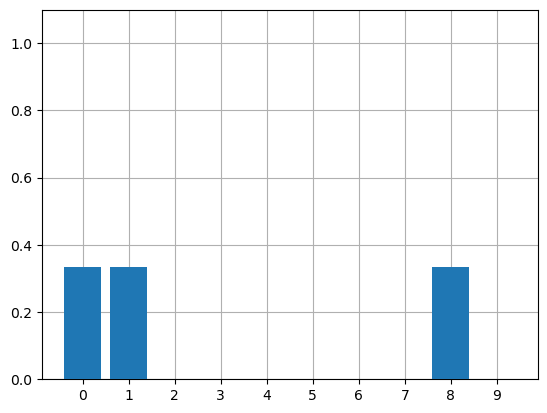

In [2]:
# display plots inside this notebook
#%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

def barPlot(belief_data, y_lim=1.1):
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    x = np.arange(len(belief_data))
    plt.xticks(x)
    plt.bar(x, belief_data, color='C0',zorder=3) # zorder to have bars in front of grid
            
belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1/3, 0])
plt.figure()
barPlot(belief)

Diese Verteilung beschreibt die Wahrscheinlichkeiten für die zehn verschiedenen Positionszustandswert des Fahrzeugs. Es ist eine *mulitmodale* Wahrscheinlichkeitsverteilung, denn es gibt drei gleich wahrscheinliche Annahmen über die mögliche Position: Türe 0, 1 oder 8. Die drei entsprechenden Balken im Histogramm sind gleich hoch. Die Bayessche Annahme ist, dass das Fahrzeug mit einer Wahrscheinlichkeit von 33,3 % vor der Türe 0, 33,3 % vor Türe 1 und 33,3 % vor Türe 8 steht.  
Multimodale Wahrscheinlichkeitsverteilungen gibt es beispielsweise auch in der Radar-Umfeldsensorik: Eine Überwachungsebene vor einem Fahrzeug wird dort in sogenannte Zellen aufgeteilt. Für jede Zelle berechnet das Radarsystem eine Wahrscheinlichkeit, dass sich darin ein Objekt befindet.  

Die Annahme *vor* der Messung war noch 10 % für jede Türe. Durch die Messung ist die neue Annahme also konkreter geworden - Wahrscheinlichkeiten von einigen Türpositionen sind auf Kosten der anderen Türpositionen größer geworden. Das Wissen über den tatsächlichen Zustandswert ist damit angewachsen.  

Die Variable `belief` für die Annahme vor der Messung wurde oben per Hand codiert. Die neue Annahme kann nun über die Variable `hallway` wie folgt berechnet werden:

In [3]:
belief = hallway * (1./3)
print(belief)

[0.33333333 0.33333333 0.         0.         0.         0.
 0.         0.         0.33333333 0.        ]


### Exemplarisches Beispiel: Konkretisierung der Positionsannahme mittels Fusion von Tür- und Bewegungsmessdaten 

Im voran gegangenen Abschnitt wurde nur eine einmalige Türmessung betrachtet. Nun sollen zwei aufeinander folgende Türmessungen und die dazwischen liegende Bewegungsmessung berücksichtigt werden. Angenommen die Messwerte haben folgende Abfolge:

  * Türsensor: Türe offen
  * Bewegungssensor: Bewegung nach Rechts
  * Türsensor: Türe offen

Kann damit die Position des Fahrzeugs bestimmt werden? Klar! Denn es gibt nur zwei offene und zugleich benachbarte Türen - die Türen 0 und 1. Also muss der Roboter bei Türe 0 gestartet sein und sich aktuell vor der Türe 1 befinden.  
Alle anderen möglichen Startpositionen stehen im Widerspruch zu den Messdaten.

Die hieraus resultierende Annahme zur Position des Roboters wird wie folgt als Wahrscheinlichkeitsverteilung ausgedrückt:

In [4]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Das Muster der geöffneten Türen war in diesem Gedankenexperiment natürlich extra so gewählt, dass schon nach der ersten Iteration die Annahme nur noch eine einzige Wahrscheinlichkeit von 100 % enthält - die Annahme also eindeutig ist.  
In der Realität findet diese Konvergenz natürlich sehr viel langsamer statt und endet selten bei 100 %. Dafür sind die Messraten der Sensoren jedoch viel höher als hier.  
Das Wesentliche wird aber auch in diesem trivialen Beispiel deutlich:  
>Nach jeder Bewegung, gefolgt von einer Messung, lokalisiert der Filter das Fahrzeug besser. Hierbei helfen nicht nur die Messwerte an sich, sondern deren Abfolge in Zusammenhang mit der Bewegung. Am Ende passt im Idealfall nur noch eine Position zum Messwertverlauf. Dies ist dann die wahre Position.  

In der realen Welt gibt es bekanntlich keine 100 %ige Sicherheit. Jede Messung ist mit einer Messunsicherheit behaftet. D.h. obwohl die Türe als offen gemessen wurde, ist es dennoch möglich, dass sie tatsächlich geschlossen war.

## Berechnung der Wahrscheinlichkeitsverteillung unter Berücksichtigung verrauschter Messdaten

Sensormesswerte sind immer verrauscht. Dies gilt auch für binäre Sensorwerte wie für den Türsensor des Roboterfahrzeugs, welcher eine geöffnete von einer geschlossenen Tür unterscheidet. Hier gibt es eine gewisse Wahrscheinlichkeit für einen Messwert "Türe offen" trotz geschlossener Türe.  
Die Annahme ``belief`` nach dem ersten Messergebnis "Türe geschlossen" muss jetzt anders berechnet werden als vorher ohne Messunsicherheit. An den Türpositionen 0, 1 und 8 mit bisher 33 % muss die Wahrscheinlichkeit reduziert und diese Reduktion  auf die übrigen Türpositionen mit bisher 0 % gleichmäßig verteilt werden.  
Wird beispielsweise davon ausgegangen, das Messergebnis sei mit einer Wahrscheinlichkeit von sieben Prozent falsch, führt das zu folgendem Array ``belief``:

```Python
[1/3, 1/3, .00, .00, .00, .00, .00, .00, 1/3, .00] # Rauschfreie Messdaten
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01] # Verrauschte Messdaten mit 7 % Messunsicherheit
```
Denn jede Position vor einer der 7 geschlossenen Türen im Array ``belief`` besitzt nun eine Wahrscheinlichkeit von 1 %. An einer - egal welcher - der sieben Positionen mit einer Wahrscheinlichkeit von je 1 % befindet sich dann das Fahrzeug mit einer Wahrscheinlichkeit von insgesamt 7 %.   

**Frage:** Kann man mit dieser Messunsicherheit immer noch das Fahrzeug lokalisieren, wie es im voran gegangenen Abschnitt unter Verwendung der Bewegungsdaten gemacht wurde?  
**Antwort:** Dies ist nach wie vor möglich. Man muss sich nur daran gewöhnen, mit Wahrscheinlichkeiten unter 100 % zu leben, d.h. nicht mit absoluter Sicherheit zu wissen, vor welcher Türe sich das Fahrzeug befindet.

Im folgenden Code wird eine Funktion ``update_belief()`` definiert, die das Array ``belief`` der Positionsannahme mit Hilfe der Messwerte `z` aktualisiert, oder anders gesagt *korrigiert*. Sie stellt wie später näher erläutert den *Korrekturschritt* des Filters dar.  
Die Variable ``correct_scale`` gibt an, **wie viel wahrscheinlicher ein korrekter Türmesswert gegenüber einem falschen ist**. Für ``correct_scale=3`` ist z.B. die Messunsicherheit 25 %, d.h. 1/4 der Messungen ergeben einen falschen Wert und 3/4 der Messungen - also dreimal so viel - ergeben den richtigen Wert.

In [5]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


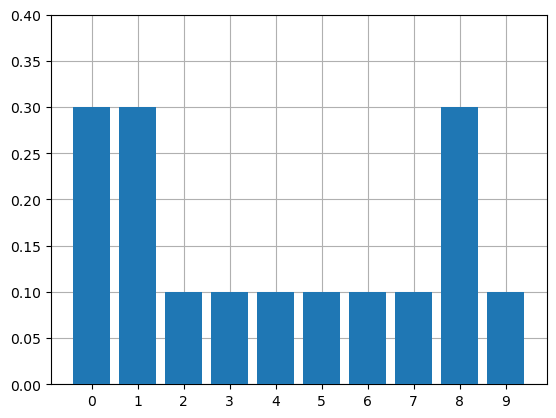

In [6]:
plt.figure()
barPlot(belief, y_lim=0.4)

Das Histogramm oben stellt die Aufenthaltswahrscheinlichkeit für die zehn Türen nach einem initialen Messwert "Türe offen" dar. Aufgrund der Messunsicherheit des Sensors sind die Balken der Türpositionen 2-7 und 9 nicht mehr Null sondern 1/3 so groß wie die Balken der Türpositionen 0, 1 und 8.  
Damit das Histogram tatsächlich eine Wahrscheinlichkeitsdichte wiedergibt, muss es aber noch normiert werden: Die Summe aller Wahrscheinlichkeiten muss Eins ergeben. Diese Normierung kann einfach mit einer ``NumPy``-Funktion durchgeführt werden.

In [7]:
belief / sum(belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

Die Funktion ``update_belief()`` wird nun durch diese Normierung erweitert und in ``scaled_update()`` umbenannt. Letztere Funktion erhält als Übergabewert nicht mehr ``correct_scale`` sondern die Wahrscheinlichkeit für eine korrekte Messung, in diesen Fall der Wert 75 % statt wie vorher den Faktor 3,0.  

Damit die Ausführungsgeschwindigkeit für größere Datensätze und viele Iterationen akzeptabel bleibt, sollte eine For-Schleife vermieden werden. Denn diese Schleife wird Schritt für Schritt im Python-Interpreter ausgeführt. Besser ist es, eine ``NumPy``-Funktion dafür zu verwenden, denn dafür werden optimierte Laufzeitbibliotheken aufgerufen, die in C oder Fortran erstellt wurden.  

Folgende Codezeile der Funktion ``scaled_update()``
```Python
belief[hallway==z] *= scale
```
ist nicht ohne größeres Pythonwissen auf Anhieb zu verstehen, daher eine kurze Erklärung:  
``hallway==z`` erzeugt ein boolsches Array mit ``True`` an den Indizes, bei denen das Array ``hallway`` den Wert ``z`` besitzt und ``False`` an den übrigen. ``belief[hallway==z]`` wählt die Arrayelemente mit diesen Indizes von ``belief`` aus. Die gesamte oben dargestellte Codezeile multipliziert dann diese Elemente mit dem Faktor ``scale``, die übrigen Elemente bleiben unberührt.

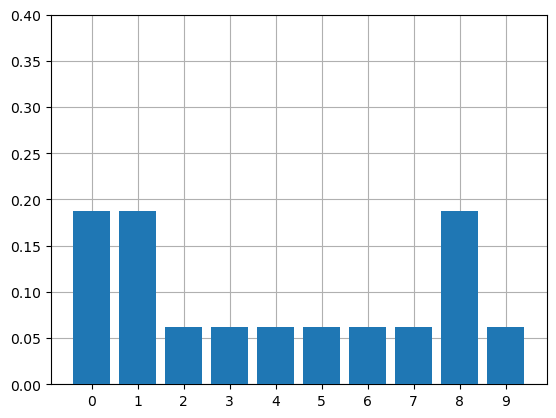

In [8]:
def scaled_update(hallway, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob) # same as correct_scale in code above
    belief[hallway==z] *= scale # replaces for loop in code of update_belief()
    belief = belief / sum(belief) # normalize to sum 1
    return belief

belief = np.array([0.1] * 10) # robot can be anywhere
updated_belief = scaled_update(hallway, belief, z=1, z_prob=.75) # Measurement "door open"
plt.figure()
barPlot(updated_belief, y_lim=0.4)

Das Histogramm oben stellt nun eine plausible Wahrscheinlichkeitsverteilung dar: Die Aufenthaltswahrscheinlichkeiten jeweils für alle offenen Türen und alle geschlossene Türen sind gleich groß. Da das Messergebnis "offene Tür" mit einer Messunsicherheit von 75 % stimmt, d.h. zu 25 % nicht stimmt, steht das Fahrzeug mit einer dreifach höheren Wahrscheinlichkeit vor einer offenen Tür als vor einer geschlossenen.  Die Summe aller Wahrscheinlichkeiten ergibt 1 - das Fahrzeug muss also irgendwo im Flur vor einer Tür stehen.

Diese oben dargestellte Positionsannahme nennt man "Posterior", genauer gesagt "A-posteriori-Wahrscheinlichkeit". Vorher ging man noch davon aus, dass das Fahrzeug mit gleicher Wahrscheinlichkeit vor jeder Türe steht. Diese vorherige Positionsannahme vor der Messung nennt man im Gegensatz dazu "Prior", genauer gesagt "A-Priori-Wahrscheinlichkeit".  
>"Posterior" ist die Wahrscheinlichkeitsverteilung *nach* Berücksichtigung einer neuen Messung. Im Gegensatz dazu nennt man die Wahrscheinlichkeitsverteilung *vor* der Messung "Prior".

Anders ausgedrückt: Prior war die Einschätzung, dass das Fahrzeug mit einer Wahrscheinlichkeit von 10 % an jeder der zehn Türen stehen kann. Durch die rauschbehaftete Messung wird ein Posterior erzeugt, bei dem berücksichtigt ist, dass es einen Sensorwert "offene Tür" gab, der ein Vertrauensniveau von 75 % besitzt.  

Der Messwert hat also die Vorhersage "Prior" korrigiert. In diesem Sinne ist Posterior die Wahrscheinlichkeitsverteilung nach der Korrektur der Vorhersage "Prior" mit Hilfe eines Messwerts.  

## Die Begriffe Prior, Likelihood und Posterior und deren Zusammenhang
Beim g-h-Filter besteht der zentrale Algorithmus aus einer Iteration, welche sich wiederum  aus einer Vorhersage und einer Korrektur zusammensetzt.
Um eine genau solche Iteration geht es im aktuellen Beispiel auch beim Bayes-Filter:  
* Bayes-Filter: Aus dem *Prior* wird in jedem Iterationsschritt unter Einbeziehung von Messdaten ein *Posterior*.  
* g-h-Filter: Es wird aus einer *Vorhersage* unter Einbeziehung von Messdaten ein *Korrekturwert* generiert.  

>Dem Begriff *Prior* entspricht also der Begriff *Vorhersagewert*, dem Begriff *Posterior* der Begriff *Korrekturwert*.  
*Positionsannahme vor der Messung:* Prior, Vorhersagewert, engl. prediction.  
*Positionsannahme nach der Messung:* Posterior, Korrekturwert, engl. update.

Der Bayes-Filter gehört also zu Recht zu den g-h-Filtern.

Der im Quellcode berechnete Wert `belief[hall==z] *= scale` ist die unnormierte Wahrscheinlichkeitsverteilung. Diese nennt man auf Englisch "Likelihood". Allgemein kann also folgende mathematische Beziehung zwischen Prior, Likelihood und Posterior aufgestellt werden:  

$$\mathtt{Posterior} = \frac{\mathtt{Likelihood} \circ \mathtt{Prior}}{\mathtt{Normierung}}$$ 

**Prior** ist also die normierte Wahrscheinlichkeitsverteilung (Positionsannahme) vor der Messung, z.B. als Ergebnis einer Vorhersage. In **Likelihood** steckt der Messwert und das Wissen über das System (hier über die Türen im Flur).  
Aus **Likelihood** und **Prior** wird die normierte Wahrscheinlichkeitsverteilung (Positionsannahme) **Posterior** nach der Messung berechnet. Man nennt sie auch Korrekturwert.  
Alle drei Größen sind (Spalten-)Vektoren derselben Dimension. **Das Produktzeichen oben "$\circ$" gibt an, dass beide Vektoren *elementweise* multipliziert werden.** Es handelt sich also nicht um ein Skalar- oder Kreuzprodukt sondern um das sogenannte "Hadamard-Produkt", dessen Namen man sich aber nicht merken muss.  
Für jede Türposition, also für jedes Element des Vektors, gibt es eine Aufenthaltswahrscheinlichkeit des Fahrzeugs aufgrund der Vorhersage (Prior) und aufgrund der Messung (Likelyhood). Diese beiden Wahrscheinlichkeiten werden miteinander multipliziert und ergeben das entsprechende Element des Posterior-Vektors.  

Der Code der Funktion ``scaled_update()`` lässt sich mit dieser Begrifflichkeit nochmals etwas vereinfachen:

In [9]:
def scaled_update(hallway, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hallway))
    likelihood[hallway==z] *= scale
    posterior = (likelihood * belief)/sum(likelihood * belief)
    return (posterior)

Die neue Korrektur-Funktion ``scaled_update()`` ist aber immer noch nicht generell anwendbar, da sie über die Variable ``hallway`` Informationen zum Flur selbst benötigt und wissen muss, wie die Messwerte dem Muster der geöffneten Türen zugeordnet sind.  
Eine allgemeine Korrektur-Funktion sollte nur die Likelihood und den Prior als Variablen übergeben bekommen und daraus den Posterior berechnen:

> Die Likelihood macht aus einem Prior zusammen mit einer anschließenden Normierung einen Posterior. In Likelyhood steckt sowohl das Messergebnis als auch dessen Interpretation (hier das Muster der geöffneten Türen), wie wahrscheinlich damit jeder der zehn Zustandswerte ist. Die unterschiedlichen Zustandswerte entsprechen jeweils den Elementen der Arrays Prior, Likelihood bzw. Posterior.

Eine wirklich generelle Korrektur-Funktion ``update()`` sollte daher so aussehen (das \*-Zeichen in Python steht für die *elementweise* Multiplikation der beiden Arrays):

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

Je nach Anwendung wird die Likelihood unterschiedlich berechnet.  
In diesem Gedankenexperiment hier geschieht das wie folgt: Der Sensor für die Türmessung gibt entweder eine 1 (Türe offen) oder eine 0 (Türe geschlossen) zurück. Entweder an den bekannten Positionen der offenen oder geschlossenen Türen wird dann im Einser-Array ``np.ones(len(hallway))`` das entsprechende Element mit dem von der Messunsicherheit abgeleiteten Wert ``scale`` multipliziert, die übrigen Elemente bleiben unverändert.

Eine anderer Sensortyp liefert beispielsweise den Winkel der Türöffnung zurück. Dann würde die Likelihood anders berechnet.  

Nachfolgend ist der Code für die (für das Gedankenexperiment spezifische) Funktion zur Berechnung der Likelihood sowie die schlussendliche Korrektur-Funktion dargestellt:

In [10]:
def lh_hallway(hallway, z, z_prob):
    """Compute likelihood that a binary door measurement matches positions in the hallway."""    
    try: # This will catch the case if there is no measurement error
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError: # Give error report
        scale = 1e8
    likelihood = np.ones(len(hallway))
    # only state of likelihood equal to z will be scaled
    likelihood[hallway==z] *= scale # [hallway==z] selects indices of positions corresponding to z
    return likelihood

def update(likelihood, prior):
    """Compute posterior based on likelihood and prior."""
    posterior = (likelihood * prior)/sum(likelihood * prior)
    return (posterior)
    
    
belief = np.array([0.1] * 10) # Initial belief: Robot can be anywhere
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)  

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

Das sequentielle Anwenden der beiden Funktionen auf den ersten Prior mit der Gleichverteilung ergibt wie erwartet das selbe Ergebnis wie im vorherigen Histogramm dargestellt.
> Im Korrektur-Schritt des Bayes-Filters wird zuerst durch eine Sensormessung eine Likelyhood in Form eines Arrays erzeugt. Dieses Array wird dann **elementweise** mit dem Array Prior (aktuelle Positionsannahme) multipliziert. Anschließend wird das Multiplikationsergebnis auf Eins normiert. Dieses Array Posterior repräsentiert dann die Positionsannahme nach der Korrektur.

## Begrifflichkeiten allgemein erklärt anhand des Gedankenexperiments mit einem Roboterfahrzeug

An diesem Punkt soll nochmals Klarheit über die Begrifflichkeiten rund um den g-h-, Bayes- oder Kalman-Filter geschaffen werden. Denn ein Verstehen des Kalman-Filters scheitert bei der Lektüre der meisten Lehrbücher leider oft (nur) an den dort verwendeten Begriffen. Thema "Herrschaftswissen" also.

* **Man versucht das *System* zu modellieren, um darauf den Filter anzuwenden.**  
In Gedankenexperiment ist das System ein Roboterfahrzeug, welches entlang eines langen Flurs fährt, von dem auf einer Seite im regelmäßigem Abstand Türen abgehen. Diese Türen sind entweder offen oder geschlossen. Statt *System* wird oft auch der Begriff *Prozess* verwendet. 

* **Der *Zustand* ist eine Eigenschaft der aktuellen Konfiguration/Konstellation des Systems die uns interessiert**  
Im Gedankenexperiment ist dies die Fahrzeugpositionen. Dieser Zustand kann 10 Werte (=Türpositionen) annehmen, die den Elementen des Arrays ``belief`` entsprechen.        

* **Den (wahren) Zustandswert kennt man meistens nicht, weshalb ein Filter angewendet wird, der dafür einen *Schätzwert* liefert.**  
Im Gedankenexperiment ist der Schätzwert die angenommene Wahrscheinlichkeitsverteilung der Fahrzeugposition (Positionsannahme). Viele Lehrbücher bringen leider die Begriffe *Zustand* und *Schätzwert* durcheinander.  

* **Ein *Messwert* ist ein aktueller Wert eines Zustandes, welcher mit Messunsicherheit gemessen wird.**  
Im Gedankenexperiment wird nicht der Zustand "Fahrzeugposition" direkt gemessen. Sondern der Messwert bezieht sich hier auf dem Status der Türe: "Türe offen" oder "Türe geschlossen".  

* **Der Filter besteht aus den beiden Iterationsschritten *Vorhersage* sowie *Messung/Korrektur*. Eine Iteration wird *Time evolution* oder auch *Systempropagation* genannt.**  
Im Gedankenexperiment ist die Systempropagation die Änderung der Fahrzeugposition mit der Zeit.  

* **Das System wird mittels eines *Prozessmodells* modelliert.**
Im Gedankenexperiment ist dies das Fahrzeug, welches dem Flur folgt und sich schrittweise vorwärts oder rückwärts von Tür zu Tür bewegt.  

* **Die Unsicherheit im *Prozessmodell* wird *Prozessrauschen*, *Systemrauschen*, *System Error* oder *Process Error* genannt.**  
Im Gedankenexperiment gibt es bisher noch keine Unsicherheit im Prozessmodell.

* **Bei einem Iterationsschritt ist die Vorhersage der neue *Prior*, die Zustandsschätzung durch die Korrektur mit Hilfe eines Messwerts nennt man *Posterior*.**  
Im Gedankenexperiment wird die Vorhersage mit Hilfe des Bewegungsmesswerts erstellt und wirkt sich als Verschiebung der Posterior-Wahrscheinlichkeitsverteilung aus, wie nachfolgend gezeigt wird.  

### Bewegtes Fahrzeug mit Einbeziehung von Bewegungsmesswerten

Nur durch die Türmessdaten kann in diesem Beispiel das Fahrzeug nicht eindeutig lokalisiert werden: Egal ob diese Messdaten rauschfrei sind oder deren Unsicherheit durch viele Wiederholmessungen reduziert wird - beispielsweise für den Messwert "Tür offen" kann das Fahrzeug nie besser lokalisiert werden als im ersten Histogramm dieses Notebooks.  
Kommen aber Bewegungsmessdaten hinzu, dann kann hier das Fahrzeug wesentlich besser lokalisiert werden: Im exemplarischen Beispiel ohne Messwertrauschen konnte die Position des Fahrzeugs sogar schon nach einer Iteration ohne Restunsicherheit bestimmt werden. Unter nicht ganz so optimalen Startbedingungen hätte es vielleicht etwas länger gedauert - aber auch hier würde die Wahrscheinlichkeitsverteilung der Fahrzeugposition schnell so konvergieren, dass man am Ende sicher weiß, wo sich das Fahrzeug befindet.    

**Frage:** Erreicht man so eine eindeutige Positionsbestimmung auch mit verrauschten Sensordaten?  
**Antwort:** Ein klares Nein. Aber meistens ist die Positionsbestimmung für die betrachtete Applikation trotzdem ausreichend.  

Man kann sich nie zu 100 % sicher sein, dass eine Annahme für einen Zustandswert wirklich der Realität entspricht. Technisch ist dies auch gar nicht gefordert. Welcher Sicherheitsingenieur gibt uns eine Garantie, dass das Kernkraftwerk in der Nachbarschaft kein Restrisiko - also ein Risiko von 0 % - eines GAUs besitzt? Ein Politiker mag das sicher tun, aber kein seriöser Ingenieur.  

Ein autonom fahrendes Auto wird übrigens auch losfahren, wenn es die Fahrbahnmarkierung nur mit einer Sicherheit von 99,999 % erkannt hat. Je nach Anwendung gibt man sich in der Technik mit einem einem entsprechenden Sicherheitsniveau zufrieden. Bei einem Staubsaugerroboter wird dieses Niveau sicherlich etwas niedriger liegen als bei einem autonom fahrenden Auto.  

Nun sollen also zusätzlich zu den Türmesswerten auch die Bewegungsmesswerte mit hinzugezogen werden. Zunächst wird angenommen, dass die Bewegungsmesswerte anders als die Türmesswerte unverrauscht sind. Im nächsten Abschnitt werden dann Messunsicherheiten mit einbezogen.   
In beiden Fällen soll mit den Bewegungsmesswerten (zusätzlich zu den Türmessdaten) die Vorhersage über die Wahrscheinlichkeitsverteilung der Fahrzeugposition konkretisiert werden. Anders ausgedrückt: Das Fahrzeug soll besser lokalisiert werden.   

### Bayes-Filter: Vorhersagen mit unverrauschten Bewegungsmessdaten

Wie muss sich die Positionsannahme ``belief`` ändern, um eine unverrauschte Bewegung mit einzubeziehen?  

Die Antwort hierauf lässt sich intuitiv finden: Bewegt sich das Roboterfahrzeug nach rechts, dann müssen alle Arrayelemente der Positionsannahme auch um eine Position nach rechts, also zu einem höheren Index, verschoben werden. Bei einer Bewegung nach Links, müssen die Elemente jeweils zum nächst kleineren Index hin rücken.  
Wenn zuvor das Fahrzeug mit hoher Wahrscheinlichkeit an Position 5 vermutet wurde, so wird es nach einer Rechtsbewegung an Position 6 vermutet.

Es gibt dabei nur ein Problem: Was passiert mit der Position 0 bei einer Bewegung nach Links bzw. für Position 9 bei einer Bewegung nach Rechts? Bisher wurde angenommen, der Flur sei perfekt gerade. Die Mathematik wird aber einfacher, wenn der Flur kreisförmig ist, und rechts neben der Türe 9 wieder die Türe 0 liegt.  
Architektonisch ist ein solcher Flur sicher eine Herausforderung, mathematisch aber nicht. Somit wird ab sofort angenommen, der Flur sei kreisförmig, und nach Türe 9 befände sich Türe 0.  

Der folgende Code beinhaltet sowohl das Versetzen der Wahrscheinlichkeitsverteilung als Reaktion auf eine Bewegung als auch die mathematische Kreisförmigkeit des Flurs:

<Figure size 640x480 with 0 Axes>

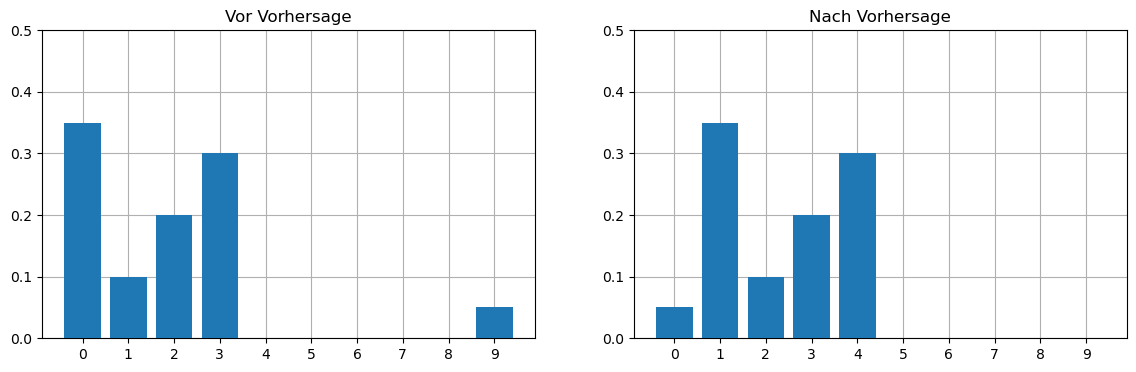

In [11]:
def perfect_predict(belief, move): # prediction without error
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n] # Modulo operator % refers to circularity of hall way
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
belief_predict = perfect_predict(belief, 1)

def twoBarPlots(plot_one, title_one, plot_two, title_two, y_lim=1.1): # Function will bei used again later
    x = np.arange(len(plot_one))
    plt.figure(figsize=(14,4))

    plt.subplot(121) # First of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_one)
    plt.bar(x,plot_one,color='C0',zorder=3)

    plt.subplot(122) # Second of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_two)
    plt.bar(x,plot_two,color='C0',zorder=3)
    
plt.figure()
twoBarPlots(belief, 'Vor Vorhersage', belief_predict, 'Nach Vorhersage', y_lim=0.5)

Vergleicht man beide Plots oben, so ist gut sichtbar, wie sich die Wahrscheinlichkeitsverteilung um eine Position nach Rechts verschoben hat. Der kleine Balken von Position 9 ist dabei auf Position 0 gerückt. Die Verteilung selbst hat sich nicht geändert, da die Bewegungsmessdaten ja ein Vertrauensniveau von 100 % d.h. keine Unsicherheiten haben.  

Der folgende Code führt diesen Vorhersageschritt zehn Mal immer erneut als Animation durch, als würde das Fahrzeug jedes Mal eine Position nach Rechts fahren. Da zwischen den Bewegungen keine neuen Türmesswerte hinzukommen, verschiebt sich die Wahrscheinlichkeitsverteilung nur jeweils um eine Position nach Rechts. Nach der 10. Iteration ist die Wahrscheinlichkeitsverteilung wieder so wie am Anfang.

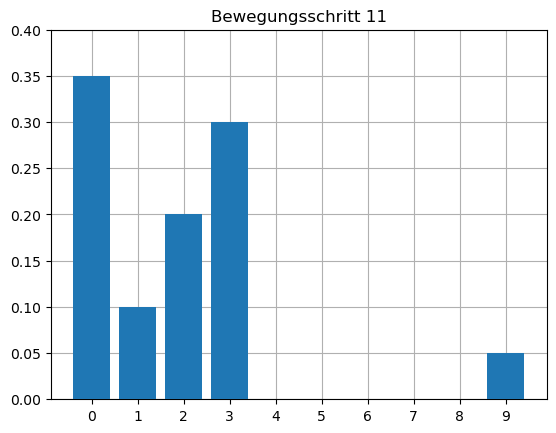

In [12]:
import time
# switch to interactive plot settings
#%matplotlib notebook

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
x = np.arange(len(belief))
fig = plt.figure()
for i in range(11):
    belief_predict = perfect_predict(belief, 1)
    plt.cla() # clear current axis (=previous plot)
    plt.bar(x,belief,color='C0',zorder=3)
    plt.grid(zorder=0)
    plt.ylim(0,0.4)
    plt.xticks(x)
    plt.title('Bewegungsschritt {}'.format(i+1))
    fig.canvas.draw() # redraw figure with current plot data
    time.sleep(0.5) # wait for 0.5 seconds
    belief = belief_predict # prediction is belief in next iteration
# reset to noninteractive plot settings    
#%matplotlib inline

**Achtung:** *Die Animation funktioniert, wenn dieses Jupyter-Notebook auf einem Server (lokal auf dem Rechner oder im Internet mit dem Webservice ``binder``) ausgeführt wird. Wird es über GitHub lediglich nur visualisiert, dann wird nur das letzte Bild der Animation angezeigt. Bei ``nbViewer`` hängt das Funktionieren der Animation davon ab, mit welchen Outputs das Jupyter-Notebook hochgeladen wurde.*  

Leider gibt es keine perfekten Sensoren ohne Messunsicherheit. Bei einem verrauschten Bewegungsmesswert wird sich die Wahrscheinlichkeitsverteilung nicht nur verschieben wie in der Animation oben. Die Verteilung selbst wird sich dabei zusätzlich *verändern*, wie in folgendem Abschnitt gezeigt wird.

### Bayes-Filter: Vorhersagen mit verrauschten Bewegungsmesswerten

Die Funktion ``perfect_predict()`` nimmt perfekte Bewegungen des Fahrzeugs an: Wurde eine Bewegung nach Rechts gemeldet so hat diese auch tatsächlich stattgefunden, und das Fahrzeug hat sich wirklich in diese Richtung um nur eine Türposition bewegt.  
**Die Bewegungsinformation stammt jedoch in der Realität von einem Sensor mit Messunsicherheit**: Es gibt z.B. eine gewisse Wahrscheinlichkeit, dass das Fahrzeug tatsächlich um zwei Türpositionen vorgerückt ist, obwohl der Sensor nur einen Schritt gemeldet hat.  

Um diese Unsicherheit zu modellieren, muss das Gedankenexperiment nochmals ausgeweitet werden:  
Das Fahrzeug soll nun nicht nur seine Fahrtrichtung ändern können, sondern auch unterschiedlich schnell fahren. Je nach Geschwindigkeit kann es jetzt dabei auch mehrere Türpositionen pro Zeitschritt vorrücken. Stellen wir uns vor, es handelt sich bei dem Roboter um einen Putzroboter, der je nach Verschmutzung unterschiedlich schnell fährt.  

Angenommen der Bewegungssensor hat ein Vertrauensniveau von 80 %, d.h. er liefert mit 80 % Wahrscheinlichkeit einen korrekten Bewegungswert. Mit jeweils 10 % Wahrscheinlichkeit misst er eine Türposition pro Sekunde zu viel bzw. zu wenig.  
Wenn der Sensor also eine Bewegung von beispielsweise vier Türpositionen (pro Sekunde) meldet, dann stimmt dies mit einer Wahrscheinlichkeit von 80 %. In 10 % der Fälle fand tatsächlich aber eine Bewegung um sogar fünf Türpositionen und in weiteren 10 % eine Bewegung um nur drei Türpositionen statt.

#### Exemplarisches Beispiel: Verrauschte Bewegungsmesswerte und unverrauschte initiale Positionsannahme
Bisher war der Input der Vorhersage eine -1, 0 oder +1 als Messwert des Bewegungssensors. Jetzt gibt der Bewegungssensor eine ganze Zahl aus, z.B. -3, 2, 0 oder +3, da sich das Roboterfahrzeug auch mehrere Positionen pro Sekunde bewegen kann. Dieser Messwert wird nun mit einem "Unsicherheits"-Array "verrauscht", in dem die o.g. Wahrscheinlichkeiten 0,1, 0,8 und 0,1 stehen, welche für die Messunsicherheiten "*eine Positionsänderung zu wenig gemessen*", "*Positionsänderung richtig gemessen*" und "*eine Positionsänderung zu viel gemessen*" stehen.     

Der Funktion ``predict_move()`` werden die aktuelle Positionsannahme, der Messwert des Bewegungssensors sowie die drei Wahrscheinlichkeiten übergeben. Sie berechnet daraus eine neue Positionsvorhersage (Prior) unter Berücksichtigung des verrauschten Bewegungsmesswerts.  
Im nachfolgenden Codebeispiel ist die initiale Positionsannahme unverrauscht: Das Fahrzeug steht mit 100 % Wahrscheinlichkeit eindeutig an Position 3. Jedoch die Bewegung um nominell 2 Positionen nach Rechts ist aufgrund der Messunsicherheit des Bewegungssensors "verrauscht". In diesem Fall ist der Übergang vom linken zum rechten Histogramm einfach nachvollziehbar: Die Bewegung *verschiebt* die Verteilung und das Rauschen *verschmiert* sie etwas. 

<Figure size 640x480 with 0 Axes>

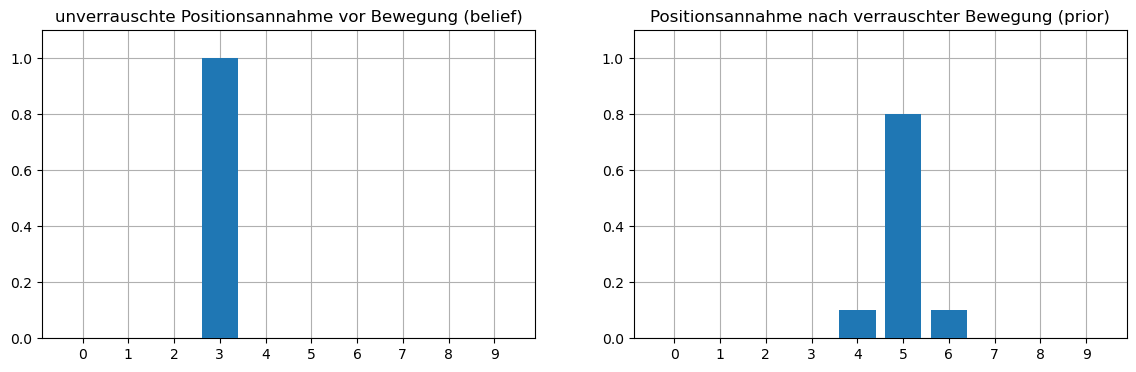

In [13]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct + # Modulo operator % refers to circularity of hall way
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1) # moved 2 door positions with +/-1 error (10%)

plt.figure()
twoBarPlots(belief, 'unverrauschte Positionsannahme vor Bewegung (belief)', prior, 
            'Positionsannahme nach verrauschter Bewegung (prior)')

#### Exemplarisches Beispiel: Verrauschte Bewegungsmesswerte und verrauschte initiale Positionsannahme
In den vorherigen Plots war die initiale Positionsannahme unverrauscht. Die Funktion ``predict_move()`` lässt sich aber genau so auf eine "verrauschte" Positionsannahme in Form eine Wahrscheinlichkeitsverteilung anwenden. Bloß das Array ``belief`` mit der Positionsannahme wird hierfür im Code entsprechend geändert:

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

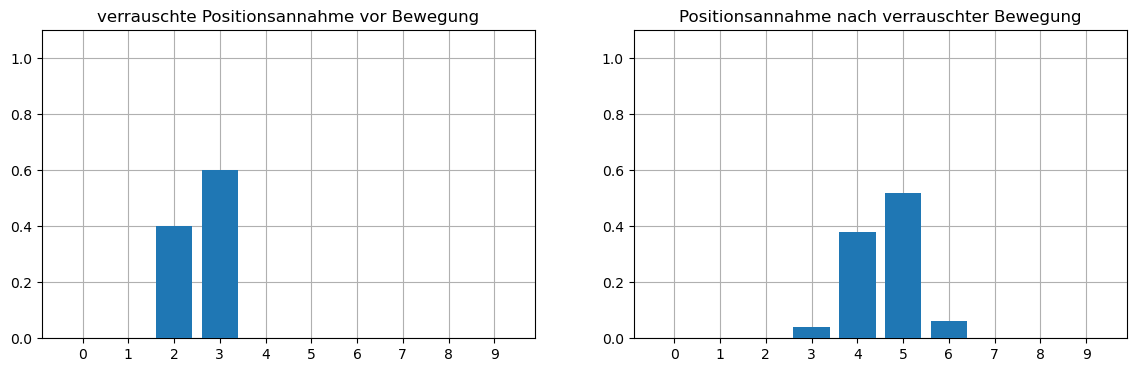

In [14]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
twoBarPlots(belief, 'verrauschte Positionsannahme vor Bewegung', prior, 'Positionsannahme nach verrauschter Bewegung')
prior

Es hat eine verrauschte Bewegung um zwei Positionen nach Rechts stattgefunden. Der Schritt vom linken zum rechten Plot ist hier schon etwas schwerer nachzuvollziehen als bei dem Beispiel mit der unverrauschten Positionsannahme.   

Wie kommen die Elemente des arrays ``prior`` zustande?  
Die 0,04 am Index 3 stammt von der 0,4 des arrays ``belief``, die mit einer Wahrscheinlichkeit von 10 % nach rechts rückt. Denn die gemessene Bewegung war zwei Positionen nach Rechts. D.h. eine Position weniger nach Rechts tritt mit einer Wahrscheinlichkeit von 10 % ein. Somit wird die 0,4 mit 0,1 multipliziert und dann eine Position nach rechts verschoben.  
Die 0,38 am Index 4 des arrays ``prior`` berechnet sich zu 0,8 mal dem Element 0,4 (Index 2) von ``belief``, denn dieses wurde ja mit einer Wahrscheinlichkeit von 80 % um zwei Positionen nach Rechts verschoben. Hinzu kommt aber noch 0,1 mal das Element 0,6 (Index 3) von ``belief``, welches mit einer Wahrscheinlichkeit von 10 % um eine Position nach Rechts verschoben wird. Dies ergibt $0,8 \cdot 0,4 + 0,1 \cdot 0,6 = 0,38$.  

>**Für das Verständnis der nachfolgenden Abschnitte ist es wichtig, diese Verkettung von Wahrscheinlichkeiten - der Wahrscheinlichkeitsverteilung der Position und der Bewegung - verstanden zu haben.**
Die Berechnung ähnelt stark einer Multiplikation eines eindimensionalen Arrays (oder Vektor) mit einem zweidimensionalen Array (oder Matrix). Die Operation die damit ausgeführt wird, ist eine *Faltung*: Die Wahrscheinlichkeitsverteilung der Position wird durch eine Faltung mit dem Bewegungsarray "verschmiert".  

"Verschmieren" ist zwar kein mathematischer Ausdruck. Es trifft diesen Prozess einer Vorhersage basierend auf verrauschte Bewegungsmesswerte aber sehr gut: Nach der Bewegung (Plot oben rechts) ist das Fahrzeug schlechter lokalisiert als vorher (Plot oben links): Die Wahrscheinlichkeitsverteilung wird niedriger und zugleich breiter.  
Das ist nicht verwunderlich, sondern war so zu erwarten: 
>Eine auf verrauschte Sensormessdaten basierende Vorhersage reduziert die Genauigkeit - also den Informationsgehalt - der Positionsannahme.  

Die folgende Animation soll dies nochmals verdeutlichen: Hier wird der Vorhersageschritt mit den selben Parametern 30 mal hintereinander durchgeführt. Bei jedem Schleifendurchlauf nimmt die Unsicherheit der Positionsannahme im Array ``belief`` zu. 

<IPython.core.display.Javascript object>


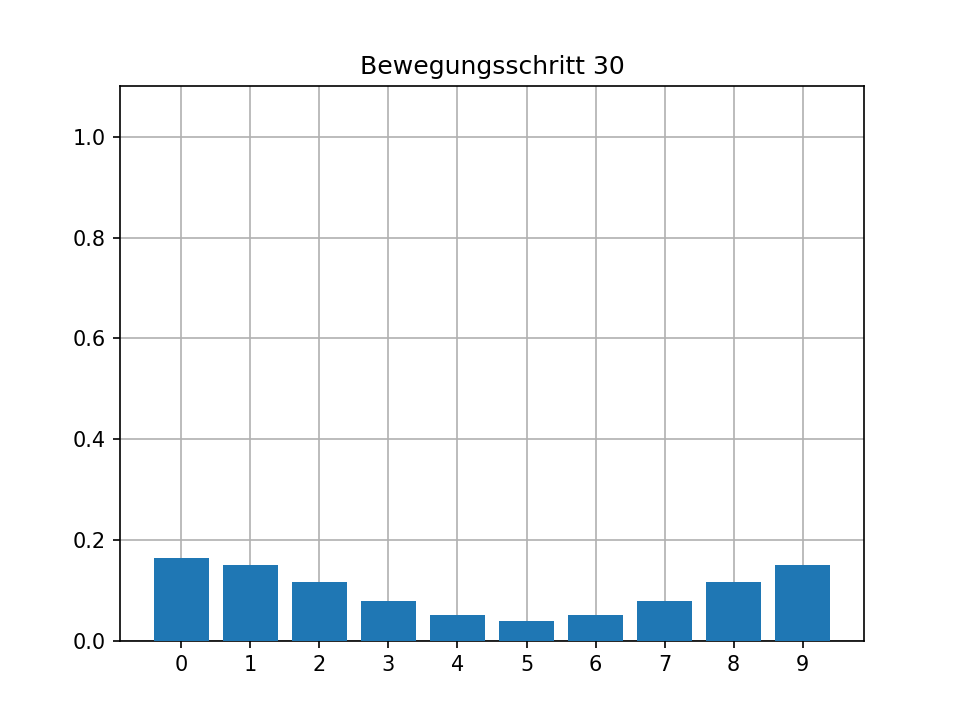

Final Belief: [0.1645062  0.1510072  0.11732805 0.07893735 0.0504189  0.04011079
 0.0504189  0.07893735 0.11732805 0.1510072 ]


In [15]:
# switch to interactive plot settings
%matplotlib notebook

belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
x = np.arange(len(belief))
fig = plt.figure()
for i in range(30):
    belief = predict_move(belief, 1, .1, .8, .1)
    plt.cla() # clear current axis (=previous plot)
    plt.bar(x,belief,color='C0',zorder=3)
    plt.grid(zorder=0)
    plt.ylim(0,1.1)
    plt.xticks(x)
    plt.title('Bewegungsschritt {}'.format(i+1))
    fig.canvas.draw() # redraw figure with current plot data
    time.sleep(0.1) # wait for 0.5 seconds
print('Final Belief:', belief)
# reset to noninteractive plot settings    
%matplotlib inline

Am Ende ergibt sich fast schon eine Gleichverteilung auf alle Türpositionen: Die Information über die Fahrzeugposition tendiert bei sehr vielen Iterationen also gegen Null.  
Ein solcher Filter macht zwar seine Arbeit korrekt, ist aber wertlos. Zum Glück gibt es zwischen jeder Vorhersage noch Türmessungen. Dadurch nimmt der Informationsgehalt bei jeder Iteration nach der Korrektur durch diese Messung wieder zu. Die Wahrscheinlichkeitsverteilung wird durch die Türmessung also wieder schmaler und zwar hoffentlich sogar *noch* schmaler als sie es vor der dem "Verschmieren" durch die Bewegungsvorhersage war.  
Im folgenden Jupyter-Notebook wird genau dies betrachtet, was der Realität entspricht und Sinn und Zweck des Filters ist.